In [1]:
import json
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# Own modules
import filepaths as fp


# 0 Loading in data

In [2]:
# Import data from json file
with open(fp.DATA_PATH / 'data.json', 'r') as file:
    retsinfo = json.load(file)

# 1 Inspecting data

In [3]:
retsinfo[0].keys()

dict_keys(['_id', 'AccessionNumber', 'DocumentTitle', 'Year', 'DiesSigni', 'Status', 'PopularTitle', 'Number', 'Ministry', 'UniqueDocumentId', 'changes', 'kapitler', 'Dato', 'url', 'dokumentType', 'shortName'])

In [4]:
# Inspecting
retsinfo[0]['kapitler'][1]['paragraffer'][0]

{'nummer': '§ 2.',
 'index': 0,
 'stk': [{'tekst': 'Ret til fravær efter denne lov omfatter alle forældre.',
   'index': 0},
  {'tekst': 'Dagpenge efter denne lov ydes i form af barselsdagpenge til lønmodtagere og selvstændige erhvervsdrivende.',
   'index': 1},
  {'tekst': 'Det er en betingelse for retten til barselsdagpenge for de personer, som er nævnt i stk. 2, at personen opfylder beskæftigelseskravet efter § 27 for lønmodtagere eller § 28 for selvstændige erhvervsdrivende.',
   'index': 2},
  {'tekst': 'Barselsdagpenge, som lønmodtagere har ret til efter stk. 2 og 3, kan udbetales til arbejdsgivere, der har udbetalt løn under fraværet, jf. § 39, stk. 1.',
   'index': 3},
  {'tekst': 'Beskæftigelsesministeren fastsætter særlige regler om barselsdagpenge til søfarende.',
   'index': 4}]}

In [5]:
retsinfo[0]['shortName']

'LBK nr 1069 af 25/09/2024'

In [6]:
# Ide: tjek længder af paragraffer. Hvis de er omkring 450 tokens kan det være at det kun er en af gangen der skal retrieves.
# Hvis det er tilfældet kan du måske frasortere alle paragraffer der er længere end 512 minus 50 tokens (context window minus maks længde genereret tekst)

rag_list = []

idx = 0

for lov in tqdm(retsinfo):
    for kapitel in lov['kapitler']:
        lov_navn = lov['shortName']
        for paragraffer in kapitel['paragraffer']:
            temp_paragraf_dict = {}
            temp_paragraf_dict['paragraf_nr'] = paragraffer['nummer']
            temp_paragraf_dict['lovnavn'] = lov_navn
            temp_paragraf_list = []
            for styk in paragraffer['stk']:
                temp_paragraf_list.append(styk['tekst'])
            temp_paragraf_dict['text'] = ' '.join(temp_paragraf_list)
            rag_list.append(temp_paragraf_dict)

100%|██████████| 1637/1637 [00:00<00:00, 17576.84it/s]


In [7]:
rag_list[5000]

{'paragraf_nr': '§ 34.',
 'lovnavn': 'LBK nr 807 af 21/06/2024',
 'text': 'Finanstilsynet kan fastsætte regler om foranstaltninger i forhold til lande og territorier med henblik på at opfylde krav eller anbefalinger fra Financial Action Task Force.'}

In [8]:
# Tokenizing all the paragraffer to see how long they generally are

from transformers import AutoTokenizer, T5ForConditionalGeneration

# Load the pretrained T5 model and tokenizer
model_name = "strombergnlp/dant5-large"  
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)


/Users/asgerkromand/miniconda3/envs/deep/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [9]:
# Creating a function to tokenize

#max_length = 512-50

def count_tokens(list):
    temp_list = []
    for item in tqdm(list):
        temp_list.append(len(tokenizer(item, return_tensors="pt", padding=True, truncation=True)['input_ids'][0]))
    return temp_list


In [10]:
# Creating the skeleton for the function with an example

len(tokenizer(rag_list[0]['text'], return_tensors="pt")['input_ids'][0])

104

In [11]:
# Creating a list of the token_lengths

test_list = [item['text'] for item in rag_list]

len_tokens = count_tokens(test_list)

100%|██████████| 42593/42593 [00:26<00:00, 1597.32it/s]


In [12]:
len(rag_list)

42593

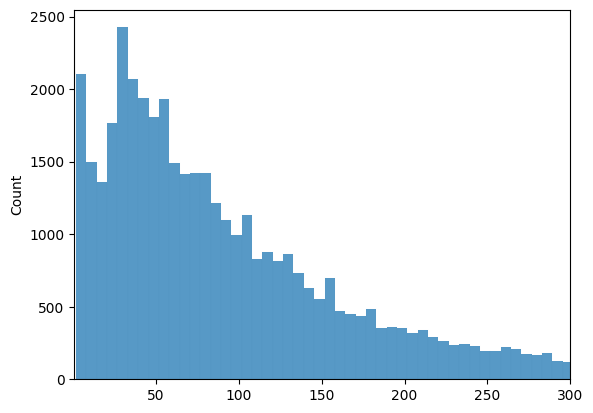

In [13]:
# Plotting the distribution of the text token lengths. This is important for RAG, as the documents being retrieved there will be on paragraf-level

fig, ax = plt.subplots()
sns.histplot(len_tokens, ax=ax)
ax.set_xlim(1, 300)
plt.show()

In [14]:
# Saving lists as txt-files

with open(fp.OUTPUT_PATH / "rag_list.txt", "w") as file:
    for item in rag_list:
        file.write(f"{item}\n")